In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
import time
import os
from scipy.stats import gamma
from scipy.special import erf, gammaincinv


In [2]:
start_time = time.time()

# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

/var/tmp/stamou/ipykernel_3445716/911792637.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


⏱️ Execution time: 1.22 seconds


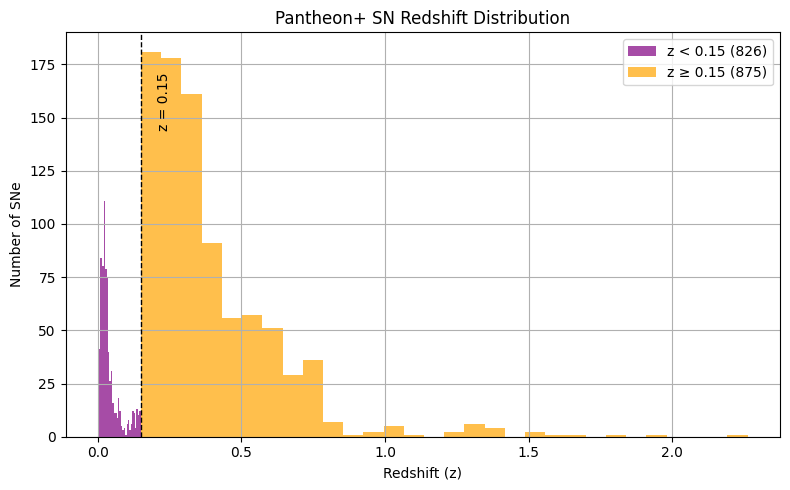

In [3]:
# Assume z is your array of redshifts from the Pantheon+ dataset
z_crit=0.15
low_z = z < z_crit
high_z = z >= z_crit

# Count SNe
n_low = np.sum(low_z)
n_high = np.sum(high_z)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(z[low_z], bins=30, color='purple', alpha=0.7, label=f'z < 0.15 ({n_low})')
plt.hist(z[high_z], bins=30, color='orange', alpha=0.7, label=f'z ≥ 0.15 ({n_high})')

# Vertical line at z=0.2
plt.axvline(z_crit, color='k', linestyle='--', linewidth=1)
plt.text(0.205, plt.ylim()[1]*0.9, 'z = 0.15', rotation=90, verticalalignment='top')

# Labels and legend
plt.xlabel('Redshift (z)')
plt.ylabel('Number of SNe')
plt.title('Pantheon+ SN Redshift Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# --- Cosmographic luminosity distance (up to second order in z) ---
def dL_cosmography(z, H0, q0):
    return (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)

# --- Theoretical distance modulus from cosmography ---
def mu_theory_notransition(z_array, H0, q0):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), H0, q0)) + 25
        for z in z_array
    ])

# --- No-transition chi-square using cosmographic expansion ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, q0 = params
    mu_model = mu_theory_notransition(z, H0, q0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M - mu_model)
    )
    return Q.T @ C_inv @ Q

# --- Objective wrapper ---
def objective_notransition(params):
    return chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv)

# --- Initial guess and bounds ---
initial_guess_notransition = [-19.3, 70.0, -0.2]  # [M, H0, q0]
bounds_notransition = [(-20, -18), (65, 80), (-1.0, 0.0)]  # wider bound for q0 allowed

# --- Minimization ---
result_notransition = minimize(
    objective_notransition,
    initial_guess_notransition,
    method='L-BFGS-B',
    options={
        'ftol': 1e-9,       # Stop when chi2 changes by less than this
        'gtol': 1e-5,       # Stop when gradient norm is small
        'maxiter': 10000,   # Give it enough steps to converge
        'disp': True        # Optional: show convergence messages
    },
    bounds=bounds_notransition
)

# --- Extract best-fit values ---
chi2_min_notransition = result_notransition.fun
M_best_notransition, H0_best_notransition, q0_best_notransition = result_notransition.x

# Determine which data points actually contribute to chi-square
mask_cosmo = (is_calibrator == 1) | (z <= 0.15)

# Count only those that matter
n_data_used = np.sum(mask_cosmo)
n_params = 3
dof_notransition = n_data_used - n_params

# Compute reduced chi-square
red_chi2_notransition = chi2_min_notransition / dof_notransition

# Goodness-of-fit probability using the corrected DoF
from scipy.stats import chi2 as chi2_dist
fit_prob_notransition = 1 - chi2_dist.cdf(chi2_min_notransition, df=dof_notransition)


# Convert H0 to h
h_best = H0_best_notransition / 100.0

# Define small steps
delta_M = 0.02
delta_q0 = 0.02
delta_h = 0.002

# 3-point grid around best-fit values
M_vals = np.array([M_best_notransition - delta_M, M_best_notransition, M_best_notransition + delta_M])
q0_vals = np.array([q0_best_notransition - delta_q0, q0_best_notransition, q0_best_notransition + delta_q0])
h_vals = np.array([h_best - delta_h, h_best, h_best + delta_h])

# Evaluate chi-square on the grid
chi2_cube = []
grid_points = []

for M in M_vals:
    for q0 in q0_vals:
        for h in h_vals:
            H0 = h * 100.0
            chi2_val = chi2_notransition([M, H0, q0], z, mB, mu_Ceph, is_calibrator, C_inv)
            chi2_cube.append(chi2_val)
            grid_points.append([M, q0, h])

chi2_cube = np.array(chi2_cube)
grid_points = np.array(grid_points)

# Build design matrix for all quadratic terms
def build_quadratic_features(X):
    M = X[:, 0]
    q0 = X[:, 1]
    h = X[:, 2]
    Φ = np.column_stack([
        M, q0, h,           # linear
        M**2, q0**2, h**2,  # squared
        M*q0, M*h, q0*h,    # cross terms
        np.ones_like(M)     # constant
    ])
    return Φ

Φ = build_quadratic_features(grid_points)

# Fit quadratic model
model = LinearRegression(fit_intercept=False)
model.fit(Φ, chi2_cube)

coeffs = model.coef_

# Extract quadratic coefficients
a1, a2, a3 = coeffs[0], coeffs[1], coeffs[2]
a4, a5, a6 = coeffs[3], coeffs[4], coeffs[5]
a7, a8, a9 = coeffs[6], coeffs[7], coeffs[8]
a0 = coeffs[9]

# Compute Fisher matrix (second derivatives)
Fisher = np.zeros((3, 3))
Fisher[0, 0] = a4       # ∂²χ²/∂M²
Fisher[1, 1] = a5       # ∂²χ²/∂q0²
Fisher[2, 2] = a6       # ∂²χ²/∂h²

Fisher[0, 1] = Fisher[1, 0] = 0.5 * a7
Fisher[0, 2] = Fisher[2, 0] = 0.5 * a8
Fisher[1, 2] = Fisher[2, 1] = 0.5 * a9

# Invert to get covariance and extract errors
cov_matrix = np.linalg.inv(Fisher)
errors = np.sqrt(np.diag(cov_matrix))

from IPython.display import Markdown, display

# Format results in LaTeX using f-strings
latex_output = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix}}$</div>

\begin{{bmatrix}}
{Fisher[0,0]:.2f} & {Fisher[0,1]:.2f} & {Fisher[0,2]:.2f} \\
{Fisher[1,0]:.2f} & {Fisher[1,1]:.2f} & {Fisher[1,2]:.2f} \\
{Fisher[2,0]:.2f} & {Fisher[2,1]:.2f} & {Fisher[2,2]:.2f}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Parameter\ Covariance\ Matrix}}$</div>

\begin{{bmatrix}}
{cov_matrix[0,0]:.2e} & {cov_matrix[0,1]:.2e} & {cov_matrix[0,2]:.2e} \\
{cov_matrix[1,0]:.2e} & {cov_matrix[1,1]:.2e} & {cov_matrix[1,2]:.2e} \\
{cov_matrix[2,0]:.2e} & {cov_matrix[2,1]:.2e} & {cov_matrix[2,2]:.2e}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Best-fit\ Values}}$</div>

\begin{{aligned}}
M &= {M_best_notransition:.5f} \pm {errors[0]:.5f} \\
q_0 &= {q0_best_notransition:.5f} \pm {errors[1]:.5f} \\
h &= {h_best:.5f} \pm {errors[2]:.5f} \\
\end{{aligned}}

<div align="center">$\Large\bf{{Fit\ Summary}}$</div>

\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_notransition:.2f} \\
\text{{Degrees of freedom}} &= {dof_notransition} \\
\chi^2_\nu &= {red_chi2_notransition:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob_notransition:.3f}
\end{{aligned}}
'''

display(Markdown(latex_output))



<div align="center">$\Large\bf{Fisher\ Matrix}$</div>

\begin{bmatrix}
27856.50 & -1546.20 & -79812.24 \\
-1546.20 & 127.50 & 4605.53 \\
-79812.24 & 4605.53 & 238584.51
\end{bmatrix}

<div align="center">$\Large\bf{Parameter\ Covariance\ Matrix}$</div>

\begin{bmatrix}
8.65e-04 & 1.24e-04 & 2.87e-04 \\
1.24e-04 & 2.59e-02 & -4.59e-04 \\
2.87e-04 & -4.59e-04 & 1.09e-04
\end{bmatrix}

<div align="center">$\Large\bf{Best-fit\ Values}$</div>

\begin{aligned}
M &= -19.24963 \pm 0.02940 \\
q_0 &= -0.38445 \pm 0.16103 \\
h &= 0.73094 \pm 0.01044 \\
\end{aligned}

<div align="center">$\Large\bf{Fit\ Summary}$</div>

\begin{aligned}
\chi^2_\text{min} &= 748.46 \\
\text{Degrees of freedom} &= 823 \\
\chi^2_\nu &= 0.91 \\
P(\chi^2 > \chi^2_\text{min}) &= 0.970
\end{aligned}


In [6]:
# Redshift cutoffs to test
z_cutoffs = [0.05, 0.10, 0.15, 0.18]

# Storage
fit_results = []

# Speed of light in km/s
c_km_s = 299792.458

# Cosmographic distance modulus using H0 (not h)
def mu_cosmo(z, H0, q0):
    dL = (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)
    return 5 * np.log10(dL) + 25

# Chi-squared with masking
def chi2_cosmo_grid(params, z, mB, mu_Ceph, is_calibrator, C_inv, z_max):
    M, H0, q0 = params
    mu_model = mu_cosmo(z, H0, q0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > z_max, 0.0, mB - M - mu_model)
    )
    return Q.T @ C_inv @ Q

# Define bounds for M, H0, q0
bounds_notransition = [(-20, -18), (65, 80), (-1.0, 0.0)]

# Loop over redshift cutoffs
for z_max in z_cutoffs:
    initial_guess = [-19.3, 70.0, -0.5]  # M, H0, q0

    result = minimize(
        chi2_cosmo_grid,
        initial_guess,
        args=(z, mB, mu_Ceph, is_calibrator, C_inv, z_max),
        method='L-BFGS-B',
        bounds=bounds_notransition,
        options={
            'ftol': 1e-9,
            'gtol': 1e-5,
            'maxiter': 20000,
            'disp': True
        }
    )

    M_best, H0_best, q0_best = result.x

    # Grid step sizes for Fisher estimation
    dM = 0.02
    dH0 = 0.2
    dq0 = 0.02

    M_vals = [M_best - dM, M_best, M_best + dM]
    H0_vals = [H0_best - dH0, H0_best, H0_best + dH0]
    q0_vals = [q0_best - dq0, q0_best, q0_best + dq0]

    grid_points = []
    chi2_vals = []

    for M in M_vals:
        for H0 in H0_vals:
            for q0 in q0_vals:
                chi2 = chi2_cosmo_grid([M, H0, q0], z, mB, mu_Ceph, is_calibrator, C_inv, z_max)
                grid_points.append([M, H0, q0])
                chi2_vals.append(chi2)

    X = np.array(grid_points)
    y = np.array(chi2_vals)

    def quadratic_features(X):
        M, H0, q0 = X[:, 0], X[:, 1], X[:, 2]
        return np.column_stack([
            M, H0, q0,
            M**2, H0**2, q0**2,
            M * H0, M * q0, H0 * q0,
            np.ones_like(M)
        ])

    Φ = quadratic_features(X)
    model = LinearRegression(fit_intercept=False).fit(Φ, y)
    coeffs = model.coef_

    # Construct Fisher matrix from 2nd derivatives
    Fisher = np.zeros((3, 3))
    Fisher[0, 0] = 2 * coeffs[3]    # d²/dM²
    Fisher[1, 1] = 2 * coeffs[4]    # d²/dH0²
    Fisher[2, 2] = 2 * coeffs[5]    # d²/dq0²
    Fisher[0, 1] = Fisher[1, 0] = coeffs[6]  # d²/dMdH0
    Fisher[0, 2] = Fisher[2, 0] = coeffs[7]  # d²/dMdq0
    Fisher[1, 2] = Fisher[2, 1] = coeffs[8]  # d²/dH0dq0
    Fisher *= 0.5

    cov = np.linalg.inv(Fisher)
    errors = np.sqrt(np.diag(cov))

    fit_results.append({
        'z_max': z_max,
        'M': M_best, 'M_err': errors[0],
        'H0': H0_best, 'H0_err': errors[1],
        'q0': q0_best, 'q0_err': errors[2]
    })

# Final DataFrame
fit_df = pd.DataFrame(fit_results)

# Print results for each z_max
for i, row in fit_df.iterrows():
    # Compute chi-square minimum at best-fit values
    chi2_min = chi2_cosmo_grid(
        [row['M'], row['H0'], row['q0']],
        z, mB, mu_Ceph, is_calibrator, C_inv,
        row['z_max']
    )

    print(f"z_max = {row['z_max']:.2f}")
    print(f"  M   = {row['M']:.5f} ± {row['M_err']:.5f}")
    print(f"  H0  = {row['H0']:.5f} ± {row['H0_err']:.5f}")
    print(f"  q0  = {row['q0']:.5f} ± {row['q0_err']:.5f}")
    print(f"  χ²  = {chi2_min:.2f}")
    print()


z_max = 0.05
  M   = -19.25075 ± 0.02941
  H0  = 72.74723 ± 1.22714
  q0  = -0.07720 ± 0.69218
  χ²  = 600.29

z_max = 0.10
  M   = -19.25008 ± 0.02941
  H0  = 73.10209 ± 1.09820
  q0  = -0.40530 ± 0.34609
  χ²  = 691.24

z_max = 0.15
  M   = -19.24963 ± 0.02940
  H0  = 73.09340 ± 1.04405
  q0  = -0.38445 ± 0.16103
  χ²  = 748.46

z_max = 0.18
  M   = -19.24865 ± 0.02940
  H0  = 72.83771 ± 1.03045
  q0  = -0.16950 ± 0.11733
  χ²  = 823.50



In [5]:
# --- Cosmographic luminosity distance (2nd-order expansion) ---
def dL_cosmography(z, H0_tr, q0_tr):
    return (c_km_s * z / H0_tr) * (1 + 0.5 * (1 - q0_tr) * z)

# --- Integration-aware mu_theory (cosmographic version) ---
def mu_theory(z_array, H0_tr, q0_tr):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), H0_tr, q0_tr)) + 25
        for z in z_array
    ])

# --- Chi-square with transition model (cosmography, z < 0.15 only) ---
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0_tr, q0_tr, d_crit = params

    mu_model = mu_theory(z, H0_tr, q0_tr)
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M_used - mu_model)
    )

    return Q.T @ C_inv @ Q

# --- Minimization wrapper ---
def objective_transition(params):
    return chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv)

# --- Optimization setup ---
# --- Optimization setup ---
initial_guess = [-19.4, -19.2, 74.0, -0.15, 19.95]
bounds = [
    (-19.50, -19.35),  # Ml
    (-19.35, -19.15),  # Mh
    (70.0, 75.0),      # h
    (-0.8, -0.1),      # om
    (19.5, 20.50)         # dcrit
]
result = minimize(
    objective_transition,
    initial_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={
        'ftol': 1e-9,       # Stop when chi2 changes by less than this
        'gtol': 1e-5,       # Stop when gradient norm is small
        'maxiter': 10000,   # Give it enough steps to converge
        'disp': True        # Optional: show convergence messages
    }

)
M_low_best, M_high_best, H0_tr_best, q0_tr_best, d_crit_best = result.x
chi2_min_transition = result.fun

# Identify contributing data points (same logic as before)
mask_cosmo = (is_calibrator == 1) | (z <= 0.15)

# Count active points
n_data_used_transition = np.sum(mask_cosmo)
n_params_transition = 5
dof_transition = n_data_used_transition - n_params_transition

# Reduced chi-square and goodness-of-fit probability
red_chi2_transition = chi2_min_transition / dof_transition
fit_prob_transition = 1 - chi2_dist.cdf(chi2_min_transition, df=dof_transition)
h_best_transition = H0_tr_best / 100.0

# --- Grid ---
delta = 0.02
Mlow_vals = np.array([M_low_best - delta, M_low_best, M_low_best + delta])
Mhigh_vals = np.array([M_high_best - delta, M_high_best, M_high_best + delta])
q0_tr_vals = np.array([q0_tr_best - delta, q0_tr_best, q0_tr_best + delta])
h_vals = np.array([h_best_transition - 0.002, h_best_transition, h_best_transition + 0.002])
dcrit_vals = np.array([d_crit_best - 0.2, d_crit_best, d_crit_best + 0.2])

grid_points_5D = []
chi2_vals_5D = []

for Mlow in Mlow_vals:
    for Mhigh in Mhigh_vals:
        for q0_tr in q0_tr_vals:
            for h in h_vals:
                for dcrit in dcrit_vals:
                    H0_tr = h * 100.0
                    chi2_val = chi2_transition([Mlow, Mhigh, H0_tr, q0_tr, dcrit], z, mB, mu_Ceph, is_calibrator, C_inv)
                    chi2_vals_5D.append(chi2_val)
                    grid_points_5D.append([Mlow, Mhigh, q0_tr, h, dcrit])

chi2_vals_5D = np.array(chi2_vals_5D)
grid_points_5D = np.array(grid_points_5D)

# --- Design matrix ---
def build_quadratic_features_5D(X):
    Mlow = X[:, 0]
    Mhigh = X[:, 1]
    q0_tr = X[:, 2]
    h = X[:, 3]
    dcrit = X[:, 4]

    return np.column_stack([
        Mlow, Mhigh, q0_tr, h, dcrit,
        Mlow**2, Mhigh**2, q0_tr**2, h**2, dcrit**2,
        Mlow*Mhigh, Mlow*q0_tr, Mlow*h, Mlow*dcrit,
        Mhigh*q0_tr, Mhigh*h, Mhigh*dcrit,
        q0_tr*h, q0_tr*dcrit, h*dcrit,
        np.ones_like(Mlow)
    ])

Φ = build_quadratic_features_5D(grid_points_5D)
model_5D = LinearRegression(fit_intercept=False)
model_5D.fit(Φ, chi2_vals_5D)
coeffs_5D = model_5D.coef_

Fisher_5D = np.zeros((5, 5))
Fisher_5D[0, 0] = 2 * coeffs_5D[5]
Fisher_5D[1, 1] = 2 * coeffs_5D[6]
Fisher_5D[2, 2] = 2 * coeffs_5D[7]
Fisher_5D[3, 3] = 2 * coeffs_5D[8]
Fisher_5D[4, 4] = 2 * coeffs_5D[9]

Fisher_5D[0, 1] = Fisher_5D[1, 0] = coeffs_5D[10]
Fisher_5D[0, 2] = Fisher_5D[2, 0] = coeffs_5D[11]
Fisher_5D[0, 3] = Fisher_5D[3, 0] = coeffs_5D[12]
Fisher_5D[0, 4] = Fisher_5D[4, 0] = coeffs_5D[13]
Fisher_5D[1, 2] = Fisher_5D[2, 1] = coeffs_5D[14]
Fisher_5D[1, 3] = Fisher_5D[3, 1] = coeffs_5D[15]
Fisher_5D[1, 4] = Fisher_5D[4, 1] = coeffs_5D[16]
Fisher_5D[2, 3] = Fisher_5D[3, 2] = coeffs_5D[17]
Fisher_5D[2, 4] = Fisher_5D[4, 2] = coeffs_5D[18]
Fisher_5D[3, 4] = Fisher_5D[4, 3] = coeffs_5D[19]

Fisher_5D *= 0.5
cov_matrix_5D = np.linalg.inv(Fisher_5D)
errors_5D = np.sqrt(np.diag(cov_matrix_5D))

latex_output_transition = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix\ (Transition\ Case)}}$</div>

\begin{{bmatrix}}
{Fisher_5D[0,0]:.2f} & {Fisher_5D[0,1]:.2f} & {Fisher_5D[0,2]:.2f} & {Fisher_5D[0,3]:.2f} & {Fisher_5D[0,4]:.2f} \\
{Fisher_5D[1,0]:.2f} & {Fisher_5D[1,1]:.2f} & {Fisher_5D[1,2]:.2f} & {Fisher_5D[1,3]:.2f} & {Fisher_5D[1,4]:.2f} \\
{Fisher_5D[2,0]:.2f} & {Fisher_5D[2,1]:.2f} & {Fisher_5D[2,2]:.2f} & {Fisher_5D[2,3]:.2f} & {Fisher_5D[2,4]:.2f} \\
{Fisher_5D[3,0]:.2f} & {Fisher_5D[3,1]:.2f} & {Fisher_5D[3,2]:.2f} & {Fisher_5D[3,3]:.2f} & {Fisher_5D[3,4]:.2f} \\
{Fisher_5D[4,0]:.2f} & {Fisher_5D[4,1]:.2f} & {Fisher_5D[4,2]:.2f} & {Fisher_5D[4,3]:.2f} & {Fisher_5D[4,4]:.2f}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Parameter\ Covariance\ Matrix\ (Transition\ Case)}}$</div>

\begin{{bmatrix}}
{cov_matrix_5D[0,0]:.2e} & {cov_matrix_5D[0,1]:.2e} & {cov_matrix_5D[0,2]:.2e} & {cov_matrix_5D[0,3]:.2e} & {cov_matrix_5D[0,4]:.2e} \\
{cov_matrix_5D[1,0]:.2e} & {cov_matrix_5D[1,1]:.2e} & {cov_matrix_5D[1,2]:.2e} & {cov_matrix_5D[1,3]:.2e} & {cov_matrix_5D[1,4]:.2e} \\
{cov_matrix_5D[2,0]:.2e} & {cov_matrix_5D[2,1]:.2e} & {cov_matrix_5D[2,2]:.2e} & {cov_matrix_5D[2,3]:.2e} & {cov_matrix_5D[2,4]:.2e} \\
{cov_matrix_5D[3,0]:.2e} & {cov_matrix_5D[3,1]:.2e} & {cov_matrix_5D[3,2]:.2e} & {cov_matrix_5D[3,3]:.2e} & {cov_matrix_5D[3,4]:.2e} \\
{cov_matrix_5D[4,0]:.2e} & {cov_matrix_5D[4,1]:.2e} & {cov_matrix_5D[4,2]:.2e} & {cov_matrix_5D[4,3]:.2e} & {cov_matrix_5D[4,4]:.2e}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Best-fit\ Values}}$</div>

\begin{{aligned}}
M_< &= {M_low_best:.5f} \pm {errors_5D[0]:.5f} \\
M_> &= {M_high_best:.5f} \pm {errors_5D[1]:.5f} \\
q_0 &= {q0_tr_best:.5f} \pm {errors_5D[2]:.5f} \\
h &= {h_best_transition:.5f} \pm {errors_5D[3]:.5f} \\
d_\text{{crit}} &= {d_crit_best:.5f} \pm {errors_5D[4]:.5f}
\end{{aligned}}

<div align="center">$\Large\bf{{Fit\ Summary}}$</div>

\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_transition:.2f} \\
\text{{Degrees of freedom}} &= {dof_transition} \\
\chi^2_\nu &= {red_chi2_transition:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob_transition:.3f}
\end{{aligned}}
'''

display(Markdown(latex_output_transition))



<div align="center">$\Large\bf{Fisher\ Matrix\ (Transition\ Case)}$</div>

\begin{bmatrix}
554.91 & -287.82 & -2.85 & -79.06 & -43.37 \\
-287.82 & 27877.22 & -1543.41 & -78240.76 & 21.61 \\
-2.85 & -1543.41 & 127.52 & 4519.60 & -1.18 \\
-79.06 & -78240.76 & 4519.60 & 229737.08 & -29.63 \\
-43.37 & 21.61 & -1.18 & -29.63 & 109.83
\end{bmatrix}

<div align="center">$\Large\bf{Parameter\ Covariance\ Matrix\ (Transition\ Case)}$</div>

\begin{bmatrix}
2.18e-03 & 5.50e-04 & 1.45e-04 & 1.85e-04 & 8.03e-04 \\
5.50e-04 & 9.52e-04 & 1.24e-04 & 3.22e-04 & 1.18e-04 \\
1.45e-04 & 1.24e-04 & 2.59e-02 & -4.68e-04 & 1.86e-04 \\
1.85e-04 & 3.22e-04 & -4.68e-04 & 1.23e-04 & 3.80e-05 \\
8.03e-04 & 1.18e-04 & 1.86e-04 & 3.80e-05 & 9.41e-03
\end{bmatrix}

<div align="center">$\Large\bf{Best-fit\ Values}$</div>

\begin{aligned}
M_< &= -19.40222 \pm 0.04666 \\
M_> &= -19.20821 \pm 0.03086 \\
q_0 &= -0.38340 \pm 0.16101 \\
h &= 0.74486 \pm 0.01110 \\
d_\text{crit} &= 19.95000 \pm 0.09701
\end{aligned}

<div align="center">$\Large\bf{Fit\ Summary}$</div>

\begin{aligned}
\chi^2_\text{min} &= 728.26 \\
\text{Degrees of freedom} &= 821 \\
\chi^2_\nu &= 0.89 \\
P(\chi^2 > \chi^2_\text{min}) &= 0.991
\end{aligned}


In [6]:
# --- AIC computation function ---
def compute_aic(chi2_min, num_params):
    """
    Compute the Akaike Information Criterion.
    AIC = chi2_min + 2 * k
    """
    return chi2_min + 2 * num_params

# --- Define model dimensions ---
k_notransition = 3  # M, H0, q0
k_transition = 5    # M_low, M_high, H0, q0, d_crit

# --- Compute AIC values ---
aic_notransition = compute_aic(chi2_min_notransition, k_notransition)
aic_transition = compute_aic(chi2_min_transition, k_transition)
delta_aic = aic_transition - aic_notransition

# --- Display AIC results in LaTeX ---
latex_output = fr"""
\begin{{aligned}}
\text{{AIC (No-Transition)}} &= {aic_notransition:.2f} \\
\text{{AIC (Transition Model)}} &= {aic_transition:.2f} \\
\Delta \mathrm{{AIC}} &= {delta_aic:.2f}
\end{{aligned}}
"""

display(Markdown(latex_output))

# --- Interpretation ---
if delta_aic > 10:
    interpretation = "Strong preference for the No-Transition model."
elif delta_aic > 5:
    interpretation = "Moderate preference for the No-Transition model."
elif delta_aic > 2:
    interpretation = "Weak preference for the No-Transition model."
elif delta_aic > -2:
    interpretation = "Models are indistinguishable."
elif delta_aic > -5:
    interpretation = "Weak preference for the Transition model."
elif delta_aic > -10:
    interpretation = "Moderate preference for the Transition model."
else:
    interpretation = "Strong preference for the Transition model."

display(Markdown(f"**AIC Interpretation**: {interpretation}"))



\begin{aligned}
\text{AIC (No-Transition)} &= 754.46 \\
\text{AIC (Transition Model)} &= 738.26 \\
\Delta \mathrm{AIC} &= -16.21
\end{aligned}


**AIC Interpretation**: Strong preference for the Transition model.

In [7]:
# --- BIC computation function ---
def compute_bic(chi2_min, num_params, num_data_points):
    """
    Compute the Bayesian Information Criterion.
    BIC = chi2_min + k * ln(n)
    """
    return chi2_min + num_params * np.log(num_data_points)

# --- Number of data points used (only z ≤ 0.15 or calibrators) ---
n_data_points = np.sum((z <= 0.15) | (is_calibrator == 1))

# --- Define model dimensions ---
k_notransition = 3  # M, H0, q0
k_transition = 5    # M_low, M_high, H0, q0, d_crit

# --- Compute BIC values ---
bic_notransition = compute_bic(chi2_min_notransition, k_notransition, n_data_points)
bic_transition = compute_bic(chi2_min_transition, k_transition, n_data_points)
delta_bic = bic_transition - bic_notransition

# --- Display BIC results in LaTeX ---
latex_output_bic = fr"""
\begin{{aligned}}
\text{{BIC (No-Transition)}} &= {bic_notransition:.2f} \\
\text{{BIC (Transition Model)}} &= {bic_transition:.2f} \\
\Delta \mathrm{{BIC}} &= {delta_bic:.2f}
\end{{aligned}}
"""

display(Markdown(latex_output_bic))

# --- Interpretation ---
if delta_bic > 10:
    interpretation_bic = "Strong preference for the No-Transition model."
elif delta_bic > 6:
    interpretation_bic = "Moderate preference for the No-Transition model."
elif delta_bic > 2:
    interpretation_bic = "Weak preference for the No-Transition model."
elif delta_bic > -2:
    interpretation_bic = "Models are indistinguishable."
elif delta_bic > -6:
    interpretation_bic = "Weak preference for the Transition model."
elif delta_bic > -10:
    interpretation_bic = "Moderate preference for the Transition model."
else:
    interpretation_bic = "Strong preference for the Transition model."

display(Markdown(f"**BIC Interpretation**: {interpretation_bic}"))



\begin{aligned}
\text{BIC (No-Transition)} &= 768.61 \\
\text{BIC (Transition Model)} &= 761.84 \\
\Delta \mathrm{BIC} &= -6.77
\end{aligned}


**BIC Interpretation**: Moderate preference for the Transition model.

In [8]:
# --- Setup ---
z_cutoffs = [0.05, 0.10, 0.15, 0.18]
c_km_s = 299792.458
fit_results = []

# --- Luminosity distance (cosmographic) ---
def dL_cosmography(z, H0, q0):
    return (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)

def mu_theory(z_array, H0, q0):
    return np.array([5 * np.log10(dL_cosmography(z, H0, q0)) + 25 for z in z_array])

# --- Transition chi-square model ---
def chi2_transition_zmax(params, z, mB, mu_Ceph, is_calibrator, C_inv, z_max):
    M_low, M_high, H0, q0, d_crit = params
    mu_model = mu_theory(z, H0, q0)
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        np.where(z > z_max, 0.0, mB - M_used - mu_model)
    )
    return Q.T @ C_inv @ Q

# --- Loop through redshift cutoffs ---
for z_max in z_cutoffs:
    initial_guess = [-19.4, -19.2, 74.0, -0.15, 19.95]
    bounds = [(-19.5, -19.35), (-19.35, -19.15), (70.0, 75.0), (-0.8, -0.1), (19.5, 20.5)]

    result = minimize(
        chi2_transition_zmax,
        initial_guess,
        args=(z, mB, mu_Ceph, is_calibrator, C_inv, z_max),
        method='L-BFGS-B',
        bounds=bounds,
        options={'ftol': 1e-9, 'gtol': 1e-5, 'maxiter': 20000, 'disp': True}
    )

    M_low, M_high, H0, q0, d_crit = result.x
    h = H0 / 100.0
    chi2_min = result.fun

    # --- Grid for Fisher estimation ---
    dM = 0.02
    dq0 = 0.02
    dh = 0.002
    dd = 0.2

    Mlow_vals = [M_low - dM, M_low, M_low + dM]
    Mhigh_vals = [M_high - dM, M_high, M_high + dM]
    q0_vals = [q0 - dq0, q0, q0 + dq0]
    h_vals = [h - dh, h, h + dh]
    dcrit_vals = [d_crit - dd, d_crit, d_crit + dd]

    grid_points = []
    chi2_vals = []

    for Ml in Mlow_vals:
        for Mh in Mhigh_vals:
            for q in q0_vals:
                for hh in h_vals:
                    for d in dcrit_vals:
                        H = hh * 100
                        chi2 = chi2_transition_zmax([Ml, Mh, H, q, d], z, mB, mu_Ceph, is_calibrator, C_inv, z_max)
                        grid_points.append([Ml, Mh, q, hh, d])
                        chi2_vals.append(chi2)

    # --- Fit quadratic model ---
    X = np.array(grid_points)
    y = np.array(chi2_vals)

    def quadratic_features_5D(X):
        Ml, Mh, q, h, d = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4]
        return np.column_stack([
            Ml, Mh, q, h, d,
            Ml**2, Mh**2, q**2, h**2, d**2,
            Ml*Mh, Ml*q, Ml*h, Ml*d,
            Mh*q, Mh*h, Mh*d,
            q*h, q*d, h*d,
            np.ones_like(Ml)
        ])

    Φ = quadratic_features_5D(X)
    model = LinearRegression(fit_intercept=False).fit(Φ, y)
    coeffs = model.coef_

    # --- Fisher matrix ---
    F = np.zeros((5, 5))
    F[0, 0] = 2 * coeffs[5]
    F[1, 1] = 2 * coeffs[6]
    F[2, 2] = 2 * coeffs[7]
    F[3, 3] = 2 * coeffs[8]
    F[4, 4] = 2 * coeffs[9]
    F[0, 1] = F[1, 0] = coeffs[10]
    F[0, 2] = F[2, 0] = coeffs[11]
    F[0, 3] = F[3, 0] = coeffs[12]
    F[0, 4] = F[4, 0] = coeffs[13]
    F[1, 2] = F[2, 1] = coeffs[14]
    F[1, 3] = F[3, 1] = coeffs[15]
    F[1, 4] = F[4, 1] = coeffs[16]
    F[2, 3] = F[3, 2] = coeffs[17]
    F[2, 4] = F[4, 2] = coeffs[18]
    F[3, 4] = F[4, 3] = coeffs[19]
    F *= 0.5

    cov = np.linalg.inv(F)
    errors = np.sqrt(np.diag(cov))

    # --- Store results ---
    fit_results.append({
        'z_max': z_max,
        'M_low': M_low, 'M_low_err': errors[0],
        'M_high': M_high, 'M_high_err': errors[1],
        'H0': H0, 'H0_err': errors[3] * 100.0,
        'q0': q0, 'q0_err': errors[2],
        'd_crit': d_crit, 'd_crit_err': errors[4],
        'chi2': chi2_min
    })

# --- Create DataFrame ---
fit_df_transition = pd.DataFrame(fit_results)

# --- Print results ---
for i, row in fit_df_transition.iterrows():
    print(f"z_max = {row['z_max']:.2f}")
    print(f"  M_low  = {row['M_low']:.5f} ± {row['M_low_err']:.5f}")
    print(f"  M_high = {row['M_high']:.5f} ± {row['M_high_err']:.5f}")
    print(f"  H0     = {row['H0']:.5f} ± {row['H0_err']:.5f}")
    print(f"  q0     = {row['q0']:.5f} ± {row['q0_err']:.5f}")
    print(f"  d_crit = {row['d_crit']:.5f} ± {row['d_crit_err']:.5f}")
    print(f"  chi_min     = {row['chi2']:.2f}")
    print()


z_max = 0.05
  M_low  = -19.40510 ± 0.04674
  M_high = -19.20891 ± 0.03086
  H0     = 74.17843 ± 1.28823
  q0     = -0.10000 ± 0.69314
  d_crit = 19.95000 ± 0.09871
  chi_min     = 579.62

z_max = 0.10
  M_low  = -19.40280 ± 0.04668
  M_high = -19.20863 ± 0.03086
  H0     = 74.49280 ± 1.16309
  q0     = -0.40165 ± 0.34593
  d_crit = 19.95000 ± 0.09735
  chi_min     = 670.99

z_max = 0.15
  M_low  = -19.40222 ± 0.04666
  M_high = -19.20821 ± 0.03086
  H0     = 74.48637 ± 1.11041
  q0     = -0.38340 ± 0.16101
  d_crit = 19.95000 ± 0.09701
  chi_min     = 728.26

z_max = 0.18
  M_low  = -19.40082 ± 0.04664
  M_high = -19.20734 ± 0.03086
  H0     = 74.22414 ± 1.09696
  q0     = -0.17002 ± 0.11733
  d_crit = 19.95000 ± 0.09617
  chi_min     = 803.41



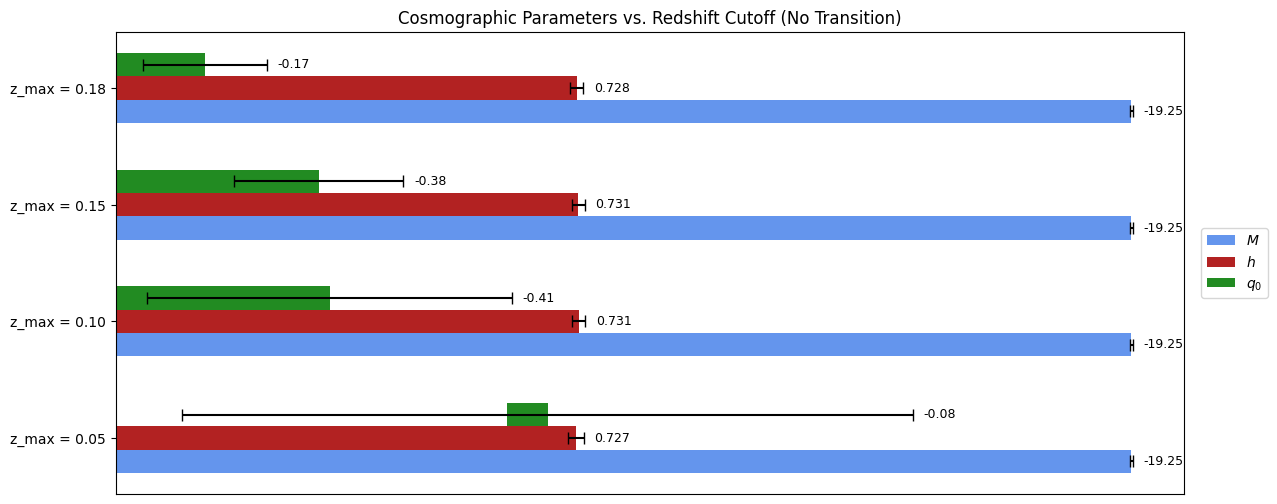

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract and convert values from DataFrame
z_vals = fit_df['z_max'].values
M_vals = fit_df['M'].values
h_vals = fit_df['H0'].values / 100  # Convert to h = H0 / 100
q0_vals = fit_df['q0'].values

M_err = fit_df['M_err'].values
h_err = fit_df['H0_err'].values / 100
q0_err = fit_df['q0_err'].values

# --- Scaling ---
h_scale = 12
q0_scale = 10

M_scaled = np.abs(M_vals)
h_scaled = h_vals * h_scale
q0_scaled = np.abs(q0_vals) * q0_scale

M_err_scaled = M_err
h_err_scaled = h_err * h_scale
q0_err_scaled = q0_err * q0_scale

# --- Plot Setup ---
n = len(z_vals)
y = np.arange(n)
bar_width = 0.2
offsets = [-bar_width, 0, bar_width]
colors = ['cornflowerblue', 'firebrick', 'forestgreen']
labels = [r"$M$", r"$h$", r"$q_0$"]

fig, ax = plt.subplots(figsize=(12, 5.5))

# M and h bars
ax.barh(y + offsets[0], M_scaled, height=bar_width, xerr=M_err_scaled,
        color=colors[0], label=labels[0], capsize=4)

ax.barh(y + offsets[1], h_scaled, height=bar_width, xerr=h_err_scaled,
        color=colors[1], label=labels[1], capsize=4)

# q0 bars, with first centered around a chosen reference value
q0_center_value = 7.8
for i in range(n):
    if i == 0:
        q0_x = q0_center_value
        bar_length = q0_scaled[i]
        left_edge = q0_x - bar_length / 2
        ax.barh(y[i] + offsets[2], bar_length, height=bar_width,
                xerr=q0_err_scaled[i], color=colors[2], capsize=4,
                left=left_edge, label=labels[2])
        ax.text(left_edge + bar_length + q0_err_scaled[i] + 0.2,
                y[i] + offsets[2], f"{q0_vals[i]:.2f}", va='center', fontsize=9)
    else:
        ax.barh(y[i] + offsets[2], q0_scaled[i], height=bar_width, xerr=q0_err_scaled[i],
                color=colors[2], capsize=4)
        ax.text(q0_scaled[i] + q0_err_scaled[i] + 0.2,
                y[i] + offsets[2], f"{q0_vals[i]:.2f}", va='center', fontsize=9)

# Labels for M and h
for i in range(n):
    ax.text(M_scaled[i] + M_err_scaled[i] + 0.2,
            y[i] + offsets[0], f"{M_vals[i]:.2f}", va='center', fontsize=9)
    ax.text(h_scaled[i] + h_err_scaled[i] + 0.2,
            y[i] + offsets[1], f"{h_vals[i]:.3f}", va='center', fontsize=9)

# Y-axis
ax.set_yticks(y)
ax.set_yticklabels([f"z_max = {z:.2f}" for z in z_vals])

ax.set_xticks([])
ax.set_xlabel("")
ax.set_xlim(left=0)
ax.set_title("Cosmographic Parameters vs. Redshift Cutoff (No Transition)")

ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))

plt.subplots_adjust(left=0.1, right=0.99, top=0.92, bottom=0.08)
plt.grid(False)
plt.savefig("cosmo_no_transition_barplot.png", dpi=300)
plt.show()


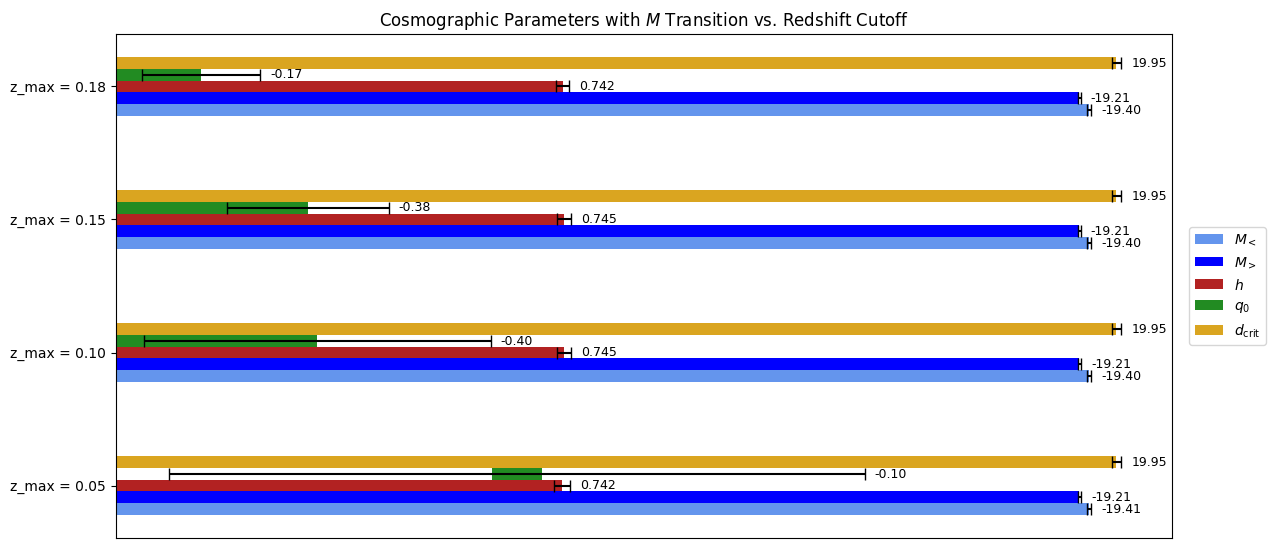

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Replace this with your real DataFrame if already available
# Example: fit_df_transition = pd.read_csv("transition_fit_results.csv")
# Assuming you have `fit_df_transition` loaded from your minimization code

# --- Extract values ---
z_vals = fit_df_transition['z_max'].values
Mlow_vals = fit_df_transition['M_low'].values
Mhigh_vals = fit_df_transition['M_high'].values
h_vals = fit_df_transition['H0'].values / 100  # Convert to h
q0_vals = fit_df_transition['q0'].values
dcrit_vals = fit_df_transition['d_crit'].values

Mlow_err = fit_df_transition['M_low_err'].values
Mhigh_err = fit_df_transition['M_high_err'].values
h_err = fit_df_transition['H0_err'].values / 100
q0_err = fit_df_transition['q0_err'].values
dcrit_err = fit_df_transition['d_crit_err'].values

# --- Scaling for display ---
h_scale = 12
q0_scale = 10

Mlow_scaled = np.abs(Mlow_vals)
Mhigh_scaled = np.abs(Mhigh_vals)
h_scaled = h_vals * h_scale
q0_scaled = np.abs(q0_vals) * q0_scale
dcrit_scaled = dcrit_vals

Mlow_err_scaled = Mlow_err
Mhigh_err_scaled = Mhigh_err
h_err_scaled = h_err * h_scale
q0_err_scaled = q0_err * q0_scale
dcrit_err_scaled = dcrit_err

# --- Plot setup ---
n = len(z_vals)
spacing_factor = 1.8
y = np.arange(n) * spacing_factor
bar_width = 0.16
offsets = [-2*bar_width, -bar_width, 0, bar_width, 2*bar_width]
colors = ['cornflowerblue', 'blue', 'firebrick', 'forestgreen', 'goldenrod']
labels = [r"$M_{<}$", r"$M_{>}$", r"$h$", r"$q_0$", r"$d_{\mathrm{crit}}$"]

fig, ax = plt.subplots(figsize=(12, 6))

# Mlow and Mhigh bars
ax.barh(y + offsets[0], Mlow_scaled, height=bar_width, xerr=Mlow_err_scaled,
        color=colors[0], label=labels[0], capsize=4)
ax.barh(y + offsets[1], Mhigh_scaled, height=bar_width, xerr=Mhigh_err_scaled,
        color=colors[1], label=labels[1], capsize=4)

# h bars
ax.barh(y + offsets[2], h_scaled, height=bar_width, xerr=h_err_scaled,
        color=colors[2], label=labels[2], capsize=4)

# q0 bars
q0_center_value = 8.0
for i in range(n):
    if i == 0:
        bar_len = q0_scaled[i]
        err = q0_err_scaled[i]
        left_edge = q0_center_value - bar_len / 2
        ax.barh(y[i] + offsets[3], bar_len, height=bar_width,
                color=colors[3], left=left_edge, label=labels[3])
        ax.errorbar(q0_center_value, y[i] + offsets[3], xerr=err,
                    fmt='none', ecolor='black', capsize=4)
        ax.text(q0_center_value + err + 0.2, y[i] + offsets[3],
                f"{q0_vals[i]:.2f}", va='center', fontsize=9)
    else:
        ax.barh(y[i] + offsets[3], q0_scaled[i], height=bar_width, xerr=q0_err_scaled[i],
                color=colors[3], capsize=4)
        ax.text(q0_scaled[i] + q0_err_scaled[i] + 0.2, y[i] + offsets[3],
                f"{q0_vals[i]:.2f}", va='center', fontsize=9)

# d_crit bars
ax.barh(y + offsets[4], dcrit_scaled, height=bar_width, xerr=dcrit_err_scaled,
        color=colors[4], label=labels[4], capsize=4)

# Annotate Mlow, Mhigh, h, d_crit
for i in range(n):
    ax.text(Mlow_scaled[i] + Mlow_err_scaled[i] + 0.2, y[i] + offsets[0],
            f"{Mlow_vals[i]:.2f}", va='center', fontsize=9)
    ax.text(Mhigh_scaled[i] + Mhigh_err_scaled[i] + 0.2, y[i] + offsets[1],
            f"{Mhigh_vals[i]:.2f}", va='center', fontsize=9)
    ax.text(h_scaled[i] + h_err_scaled[i] + 0.2, y[i] + offsets[2],
            f"{h_vals[i]:.3f}", va='center', fontsize=9)
    ax.text(dcrit_scaled[i] + dcrit_err_scaled[i] + 0.2, y[i] + offsets[4],
            f"{dcrit_vals[i]:.2f}", va='center', fontsize=9)

# Y-axis labels
ax.set_yticks(y)
ax.set_yticklabels([f"z_max = {z:.2f}" for z in z_vals])

# Final formatting
ax.set_xticks([])
ax.set_xlim(left=0)
ax.set_title("Cosmographic Parameters with $M$ Transition vs. Redshift Cutoff")
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.subplots_adjust(left=0.1, right=0.98, top=0.92, bottom=0.08)
plt.grid(False)

plt.savefig("cosmo_transition_barplot.png", dpi=300)
plt.show()


In [11]:
# Recompute chi2 at best-fit parameters for each z_max
chi2_min_vals = []

for i, row in fit_df_transition.iterrows():
    params = [row['M_low'], row['M_high'], row['H0'], row['q0'], row['d_crit']]
    chi2_val = chi2_transition_zmax(params, z, mB, mu_Ceph, is_calibrator, C_inv, row['z_max'])
    chi2_min_vals.append(chi2_val)

fit_df_transition['chi2'] = chi2_min_vals

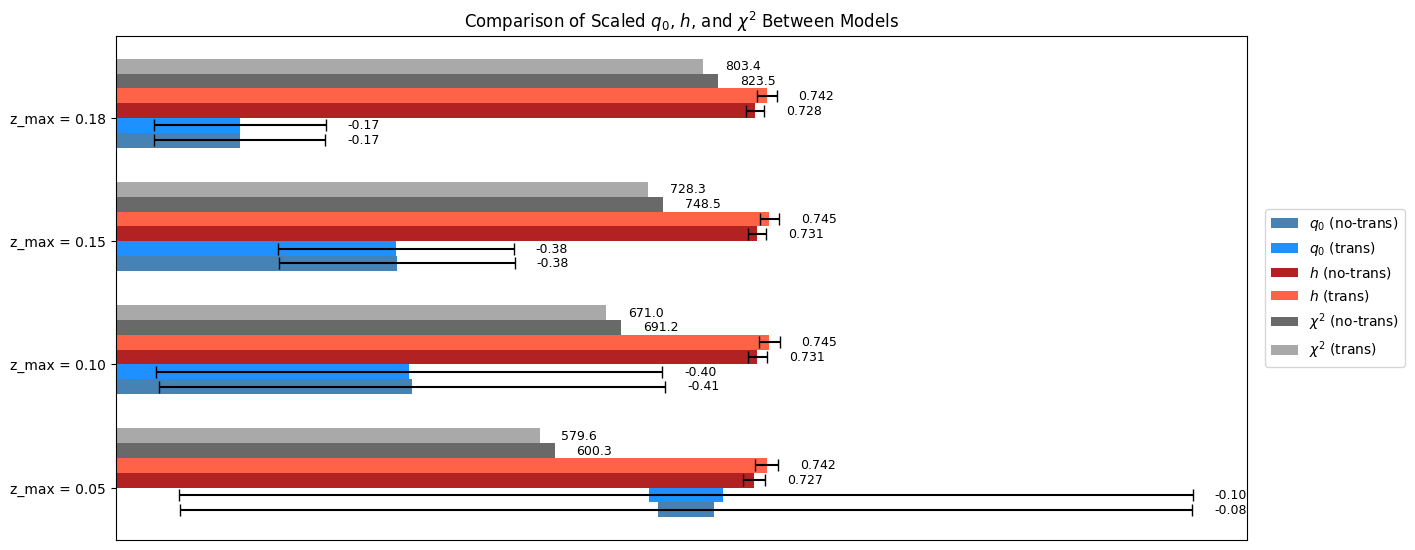

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# z values from original setup
z_vals = fit_df['z_max'].values

# No-transition model
q0_notrans = fit_df['q0'].values
q0_err_notrans = fit_df['q0_err'].values
h_notrans = fit_df['H0'].values / 100
h_err_notrans = fit_df['H0_err'].values / 100
chi2_notrans = [chi2_cosmo_grid([row['M'], row['H0'], row['q0']],
                                z, mB, mu_Ceph, is_calibrator, C_inv,
                                row['z_max']) for _, row in fit_df.iterrows()]

# Transition model
q0_trans = fit_df_transition['q0'].values
q0_err_trans = fit_df_transition['q0_err'].values
h_trans = fit_df_transition['H0'].values / 100
h_err_trans = fit_df_transition['H0_err'].values / 100
chi2_trans = fit_df_transition['chi2'].values

# --- Scaling ---
q0_scale = 10
h_scale = 12
chi2_scale = 0.01

q0_notrans_scaled = np.abs(q0_notrans) * q0_scale
q0_trans_scaled = np.abs(q0_trans) * q0_scale
h_notrans_scaled = h_notrans * h_scale
h_trans_scaled = h_trans * h_scale
chi2_notrans_scaled = np.array(chi2_notrans) * chi2_scale
chi2_trans_scaled = chi2_trans * chi2_scale

q0_err_notrans_scaled = q0_err_notrans * q0_scale
q0_err_trans_scaled = q0_err_trans * q0_scale
h_err_notrans_scaled = h_err_notrans * h_scale
h_err_trans_scaled = h_err_trans * h_scale

# --- Plotting ---
n = len(z_vals)
y = np.arange(n)
bar_width = 0.12
offsets = [-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width, 2.5*bar_width, 3.5*bar_width]
colors = ['steelblue', 'dodgerblue', 'firebrick', 'tomato', 'dimgray', 'darkgray']
labels = [r"$q_0$ (no-trans)", r"$q_0$ (trans)",
          r"$h$ (no-trans)", r"$h$ (trans)",
          r"$\chi^2$ (no-trans)", r"$\chi^2$ (trans)"]

fig, ax = plt.subplots(figsize=(13, 6))

# --- q0 bars with centering on first row ---
q0_center_value = 7.8
for i in range(n):
    # No-transition q0
    if i == 0:
        left = q0_center_value - q0_notrans_scaled[i] / 2
        ax.barh(y[i] + offsets[0], q0_notrans_scaled[i], height=bar_width,
                color=colors[0], left=left, capsize=4, label=labels[0])
        ax.errorbar(q0_center_value, y[i] + offsets[0], xerr=q0_err_notrans_scaled[i],
                    fmt='none', ecolor='black', capsize=4)
        ax.text(q0_center_value + q0_err_notrans_scaled[i] + 0.3, y[i] + offsets[0],
                f"{q0_notrans[i]:.2f}", va='center', fontsize=9)
    else:
        ax.barh(y[i] + offsets[0], q0_notrans_scaled[i], height=bar_width,
                xerr=q0_err_notrans_scaled[i], color=colors[0], capsize=4)
        ax.text(q0_notrans_scaled[i] + q0_err_notrans_scaled[i] + 0.3, y[i] + offsets[0],
                f"{q0_notrans[i]:.2f}", va='center', fontsize=9)

    # Transition q0
    if i == 0:
        left = q0_center_value - q0_trans_scaled[i] / 2
        ax.barh(y[i] + offsets[1], q0_trans_scaled[i], height=bar_width,
                color=colors[1], left=left, capsize=4, label=labels[1])
        ax.errorbar(q0_center_value, y[i] + offsets[1], xerr=q0_err_trans_scaled[i],
                    fmt='none', ecolor='black', capsize=4)
        ax.text(q0_center_value + q0_err_trans_scaled[i] + 0.3, y[i] + offsets[1],
                f"{q0_trans[i]:.2f}", va='center', fontsize=9)
    else:
        ax.barh(y[i] + offsets[1], q0_trans_scaled[i], height=bar_width,
                xerr=q0_err_trans_scaled[i], color=colors[1], capsize=4)
        ax.text(q0_trans_scaled[i] + q0_err_trans_scaled[i] + 0.3, y[i] + offsets[1],
                f"{q0_trans[i]:.2f}", va='center', fontsize=9)

# h bars + labels
for i in range(n):
    ax.text(h_notrans_scaled[i] + h_err_notrans_scaled[i] + 0.3, y[i] + offsets[2],
            f"{h_notrans[i]:.3f}", va='center', fontsize=9)
    ax.text(h_trans_scaled[i] + h_err_trans_scaled[i] + 0.3, y[i] + offsets[3],
            f"{h_trans[i]:.3f}", va='center', fontsize=9)

ax.barh(y + offsets[2], h_notrans_scaled, height=bar_width, xerr=h_err_notrans_scaled,
        color=colors[2], label=labels[2], capsize=4)
ax.barh(y + offsets[3], h_trans_scaled, height=bar_width, xerr=h_err_trans_scaled,
        color=colors[3], label=labels[3], capsize=4)

# chi2 bars + labels
for i in range(n):
    ax.text(chi2_notrans_scaled[i] + 0.3, y[i] + offsets[4],
            f"{chi2_notrans[i]:.1f}", va='center', fontsize=9)
    ax.text(chi2_trans_scaled[i] + 0.3, y[i] + offsets[5],
            f"{chi2_trans[i]:.1f}", va='center', fontsize=9)

ax.barh(y + offsets[4], chi2_notrans_scaled, height=bar_width,
        color=colors[4], label=labels[4])
ax.barh(y + offsets[5], chi2_trans_scaled, height=bar_width,
        color=colors[5], label=labels[5])

# Labels and layout
ax.set_yticks(y)
ax.set_yticklabels([f"z_max = {z:.2f}" for z in z_vals])
ax.set_xticks([])
ax.set_xlim(left=0)
ax.set_title("Comparison of Scaled $q_0$, $h$, and $\chi^2$ Between Models")
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.subplots_adjust(left=0.1, right=0.97, top=0.92, bottom=0.08)
plt.grid(False)
plt.savefig("comparison_q0_h_chi2_scaled_centered_annotated.png", dpi=300)
plt.show()



In [13]:
# --- AIC Calculation for Cosmographic Case ---

def compute_aic(chi2_min, num_params):
    """
    Compute the Akaike Information Criterion.
    AIC = chi2_min + 2 * k
    """
    return chi2_min + 2 * num_params

# Define model details
chi2_no_transition = chi2_min_notransition      # from cosmographic no-transition fit
chi2_transition = chi2_min_transition           # from cosmographic transition fit

k_no_transition = 3   # M, H0, q0
k_transition = 5      # M<, M>, H0, q0, d_crit

# Compute AIC values
aic_no_transition = compute_aic(chi2_no_transition, k_no_transition)
aic_transition = compute_aic(chi2_transition, k_transition)

# Compare
delta_aic = aic_transition - aic_no_transition

# Build LaTeX output
latex_output = fr"""

\begin{{aligned}}
\text{{AIC (No-Transition, Cosmography)}} &= {aic_no_transition:.2f} \\
\text{{AIC (Transition Model, Cosmography)}} &= {aic_transition:.2f} \\
\Delta \mathrm{{AIC}} &= {delta_aic:.2f}
\end{{aligned}}
"""

# Display result
display(Markdown(latex_output))

# Interpretation
if delta_aic > 10:
    interpretation = "Strong preference for the No-Transition model."
elif delta_aic > 5:
    interpretation = "Moderate preference for the No-Transition model."
elif delta_aic > 2:
    interpretation = "Weak preference for the No-Transition model."
elif delta_aic > -2:
    interpretation = "Models are indistinguishable."
elif delta_aic > -5:
    interpretation = "Weak preference for the Transition model."
elif delta_aic > -10:
    interpretation = "Moderate preference for the Transition model."
else:
    interpretation = "Strong preference for the Transition model."

display(Markdown(f"**Interpretation**: {interpretation}"))




\begin{aligned}
\text{AIC (No-Transition, Cosmography)} &= 754.46 \\
\text{AIC (Transition Model, Cosmography)} &= 738.26 \\
\Delta \mathrm{AIC} &= -16.21
\end{aligned}


**Interpretation**: Strong preference for the Transition model.

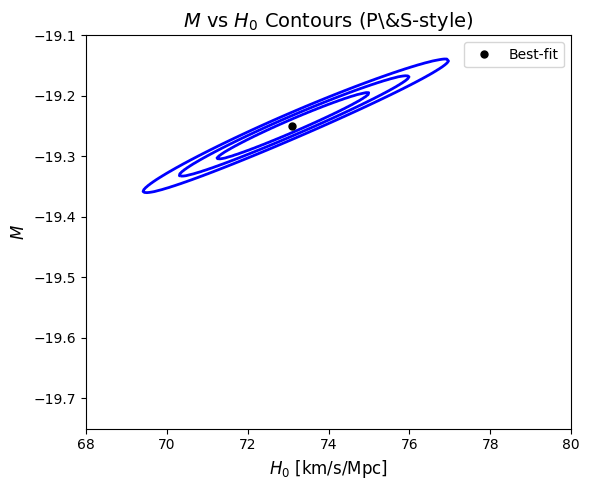

⏱️ Execution time: 220.23 seconds


In [6]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0, q0):
    return (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)

def mu_theory(z_array, H0, q0):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0), float(q0))) + 25
        for z in z_array
    ])

# --- Chi2 for no-transition model (cosmographic, z < 0.15) ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, q0 = params
    mu_model = mu_theory(z, H0, q0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M - mu_model)
    )
    return Q.T @ C_inv @ Q

# --- Gamma-based Δχ² thresholds (dof = 3) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 3) for n in [1, 2, 3]]

# --- Grid setup for M vs H0 ---
M_range = np.linspace(-19.75, -19.10, 200)
H0_range = np.linspace(68, 80, 200)

# --- Load best-fit values from cosmographic no-transition minimization ---
M_best = M_best_notransition
H0_best = H0_best_notransition
q0_best = q0_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M, H0, q0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
        for H0 in H0_range
    ]
    for M in M_range
])

# --- Save data ---
np.savez("contour_data/contour_data_M_H0_cosmography.npz",
         M=M_range, H0=H0_range, chi2=chi2_grid,
         M_best=M_best, H0_best=H0_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, q0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(H0_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

# (NO σ LABELS)
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_H0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


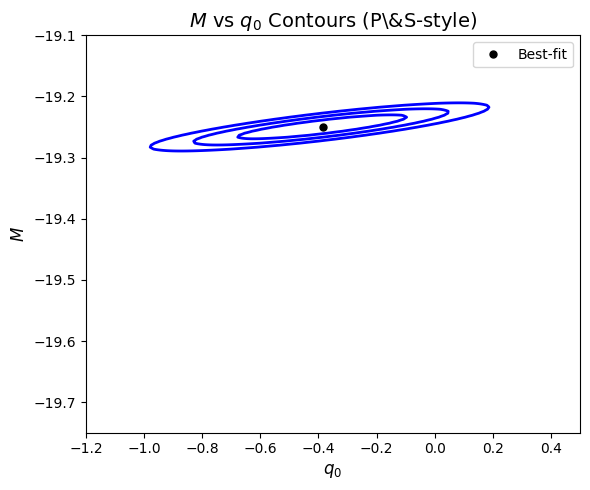

⏱️ Execution time: 162.81 seconds


In [41]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0, q0):
    return (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)

def mu_theory(z_array, H0, q0):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0), float(q0))) + 25
        for z in z_array
    ])

# --- Chi2 for no-transition model (cosmographic, z < 0.15) ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, q0 = params
    mu_model = mu_theory(z, H0, q0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M - mu_model)
    )
    return Q.T @ C_inv @ Q

# --- Gamma-based Δχ² thresholds (dof = 3) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 3) for n in [1, 2, 3]]

# --- Grid setup for M vs q0 ---
M_range = np.linspace(-19.75, -19.10, 200)
q0_range = np.linspace(-1.2, 0.5, 200)

# --- Load best-fit values from cosmographic no-transition minimization ---
M_best = M_best_notransition
H0_best = H0_best_notransition
q0_best = q0_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M, H0_best, q0], z, mB, mu_Ceph, is_calibrator, C_inv)
        for q0 in q0_range
    ]
    for M in M_range
])

# --- Save data ---
np.savez("contour_data/contour_data_M_q0_cosmography.npz",
         M=M_range, q0=q0_range, chi2=chi2_grid,
         M_best=M_best, q0_best=q0_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, q0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(q0_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(q0_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$q_0$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $q_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_q0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


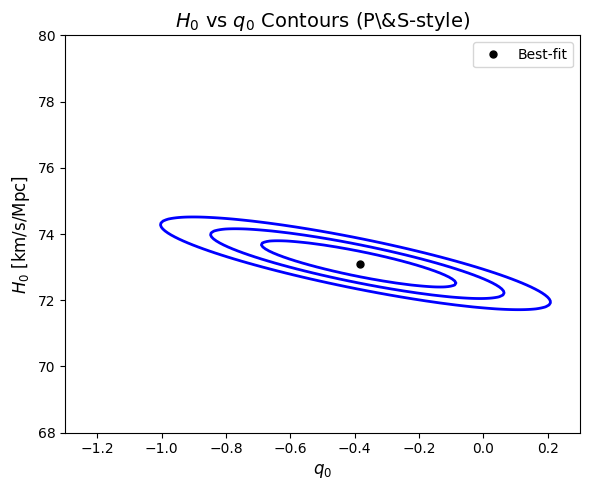

⏱️ Execution time: 195.19 seconds


In [8]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0, q0):
    return (c_km_s * z / H0) * (1 + 0.5 * (1 - q0) * z)

def mu_theory(z_array, H0, q0):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0), float(q0))) + 25
        for z in z_array
    ])

# --- Chi2 for no-transition model (cosmographic, z < 0.15) ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, q0 = params
    mu_model = mu_theory(z, H0, q0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z > 0.15, 0.0, mB - M - mu_model)
    )
    return Q.T @ C_inv @ Q

# --- Gamma-based Δχ² thresholds (dof = 3) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 3) for n in [1, 2, 3]]

# --- Grid setup for H0 vs q0 ---
H0_range = np.linspace(68, 80, 200)
q0_range = np.linspace(-1.3, 0.3, 200)

# --- Load best-fit values from cosmographic no-transition minimization ---
M_best = M_best_notransition
H0_best = H0_best_notransition
q0_best = q0_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M_best, H0, q0], z, mB, mu_Ceph, is_calibrator, C_inv)
        for q0 in q0_range
    ]
    for H0 in H0_range
])

# --- Save data ---
np.savez("contour_data/contour_data_H0_q0_cosmography.npz",
         H0=H0_range, q0=q0_range, chi2=chi2_grid,
         H0_best=H0_best, q0_best=q0_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, q0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(q0_range, H0_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(q0_best, H0_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$q_0$", fontsize=12)
plt.ylabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.title(r"$H_0$ vs $q_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("H0_vs_q0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


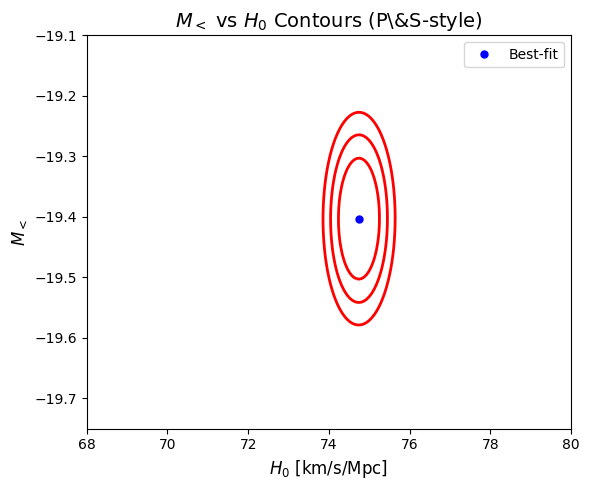

⏱️ Execution time: 329.75 seconds


In [13]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0_tr, q0_tr):
    return (c_km_s * z / H0_tr) * (1 + 0.5 * (1 - q0_tr) * z)

def mu_theory(z_array, H0_tr, q0_tr):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0_tr), float(q0_tr))) + 25
        for z in z_array
    ])

# --- Cosmographic chi-square function with transition ---
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0_tr, q0_tr, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0_tr, q0_tr)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = 0.0 if z[i] > 0.15 else mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Define Gamma-based contour thresholds (P&S-style) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]  # 5 parameters

# --- Grid setup ---
Mlow_range = np.linspace(-19.75, -19.10, 200)
H0_tr_range = np.linspace(68, 80, 200)

# --- Load best-fit values (from previous cosmographic transition minimization) ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_tr_best = H0_tr_best
q0_tr_best = q0_tr_best
d_crit_best = d_crit_best
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low, M_high_best, H0_tr, q0_tr_best, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for H0_tr in H0_tr_range
    ]
    for M_low in Mlow_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mlow_H0_cosmography.npz",
         Mlow=Mlow_range, H0_tr=H0_tr_range, chi2=chi2_grid,
         M_low_best=M_low_best, H0_tr_best=H0_tr_best)

# --- Plot ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_tr_range, Mlow_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(H0_tr_best, M_low_best, 'bo', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_<$", fontsize=12)
plt.title(r"$M_<$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_H0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


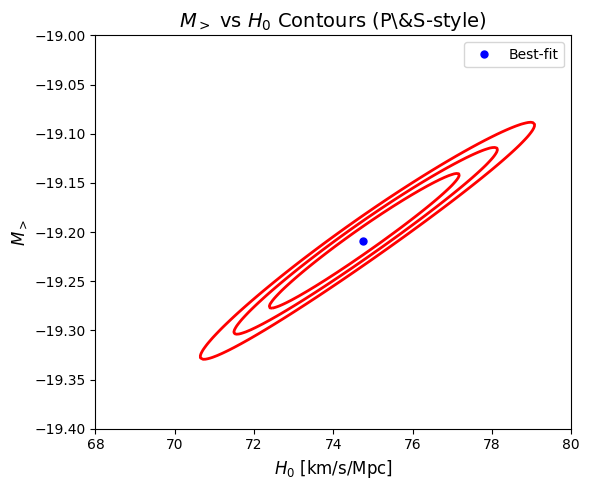

⏱️ Execution time: 330.38 seconds


In [19]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0_tr, q0_tr):
    return (c_km_s * z / H0_tr) * (1 + 0.5 * (1 - q0_tr) * z)

def mu_theory(z_array, H0_tr, q0_tr):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0_tr), float(q0_tr))) + 25
        for z in z_array
    ])

# --- Cosmographic chi-square function with transition ---
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0_tr, q0_tr, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0_tr, q0_tr)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = 0.0 if z[i] > 0.15 else mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Define Gamma-based contour thresholds (P&S-style) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]  # 5 parameters

# --- Grid setup ---
Mhigh_range = np.linspace(-19.40, -19.00, 200)
H0_tr_range = np.linspace(68, 80, 200)

# --- Best-fit values from cosmographic transition minimization ---
M_low_best, M_high_best, H0_tr_best, q0_tr_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low_best, M_high, H0_tr, q0_tr_best, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for H0_tr in H0_tr_range
    ]
    for M_high in Mhigh_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mhigh_H0_cosmography.npz",
         Mhigh=Mhigh_range, H0_tr=H0_tr_range, chi2=chi2_grid,
         M_high_best=M_high_best, H0_tr_best=H0_tr_best)

# --- Plot ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min_transition

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_tr_range, Mhigh_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(H0_tr_best, M_high_best, 'bo', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_>$", fontsize=12)
plt.title(r"$M_>$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_H0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


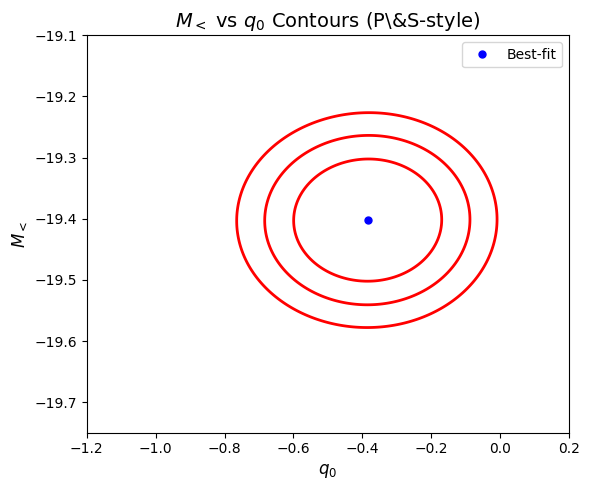

⏱️ Execution time: 357.60 seconds


In [7]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0_tr, q0_tr):
    return (c_km_s * z / H0_tr) * (1 + 0.5 * (1 - q0_tr) * z)

def mu_theory(z_array, H0_tr, q0_tr):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0_tr), float(q0_tr))) + 25
        for z in z_array
    ])

# --- Cosmographic chi-square function with transition ---
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0_tr, q0_tr, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0_tr, q0_tr)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = 0.0 if z[i] > 0.15 else mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Define Gamma-based contour thresholds (P&S-style) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]  # 5 parameters

# --- Grid setup ---
Mlow_range = np.linspace(-19.75, -19.10, 200)
q0_tr_range = np.linspace(-1.2, 0.2, 200)

# --- Best-fit values from cosmographic transition minimization ---
M_low_best, M_high_best, H0_tr_best, q0_tr_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low, M_high_best, H0_tr_best, q0_tr, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for q0_tr in q0_tr_range
    ]
    for M_low in Mlow_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mlow_q0_cosmography.npz",
         Mlow=Mlow_range, q0_tr=q0_tr_range, chi2=chi2_grid,
         M_low_best=M_low_best, q0_tr_best=q0_tr_best)

# --- Plot ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(q0_tr_range, Mlow_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(q0_tr_best, M_low_best, 'bo', label='Best-fit', markersize=5)

plt.xlabel(r"$q_0$", fontsize=12)
plt.ylabel(r"$M_<$", fontsize=12)
plt.title(r"$M_<$ vs $q_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_q0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

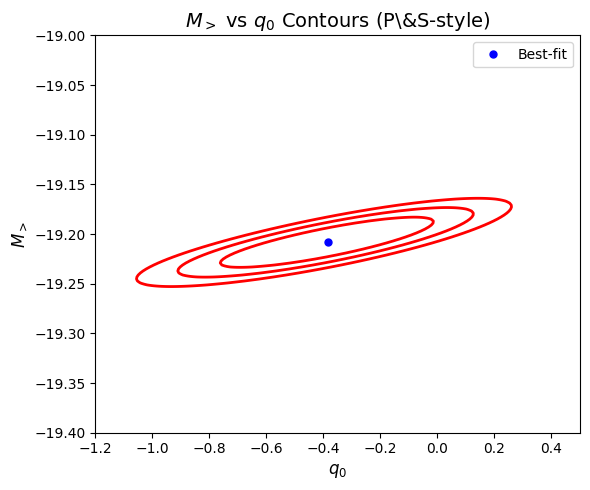

⏱️ Execution time: 412.53 seconds


In [8]:
start_time = time.time()

# --- Cosmographic luminosity distance (no integration needed) ---
def dL_cosmography(z, H0_tr, q0_tr):
    return (c_km_s * z / H0_tr) * (1 + 0.5 * (1 - q0_tr) * z)

def mu_theory(z_array, H0_tr, q0_tr):
    return np.array([
        5 * np.log10(dL_cosmography(float(z), float(H0_tr), float(q0_tr))) + 25
        for z in z_array
    ])

# --- Cosmographic chi-square function with transition ---
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0_tr, q0_tr, mu_crit = params
    Q = []
    for i in range(len(z)):
        mu_model = mu_theory([z[i]], H0_tr, q0_tr)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = 0.0 if z[i] > 0.15 else mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Define Gamma-based contour thresholds (P&S-style) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]  # 5 parameters

# --- Grid setup ---
Mhigh_range = np.linspace(-19.40, -19.00, 200)
q0_tr_range = np.linspace(-1.2, 0.5, 200)

# --- Best-fit values from cosmographic transition minimization ---
M_low_best, M_high_best, H0_tr_best, q0_tr_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition(
            [M_low_best, M_high, H0_tr_best, q0_tr, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for q0_tr in q0_tr_range
    ]
    for M_high in Mhigh_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mhigh_q0_cosmography.npz",
         Mhigh=Mhigh_range, q0_tr=q0_tr_range, chi2=chi2_grid,
         M_high_best=M_high_best, q0_tr_best=q0_tr_best)

# --- Plot ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min_transition

plt.figure(figsize=(6, 5))
CS = plt.contour(q0_tr_range, Mhigh_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(q0_tr_best, M_high_best, 'bo', label='Best-fit', markersize=5)

plt.xlabel(r"$q_0$", fontsize=12)
plt.ylabel(r"$M_>$", fontsize=12)
plt.title(r"$M_>$ vs $q_0$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_q0_PandS_style_cosmography.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


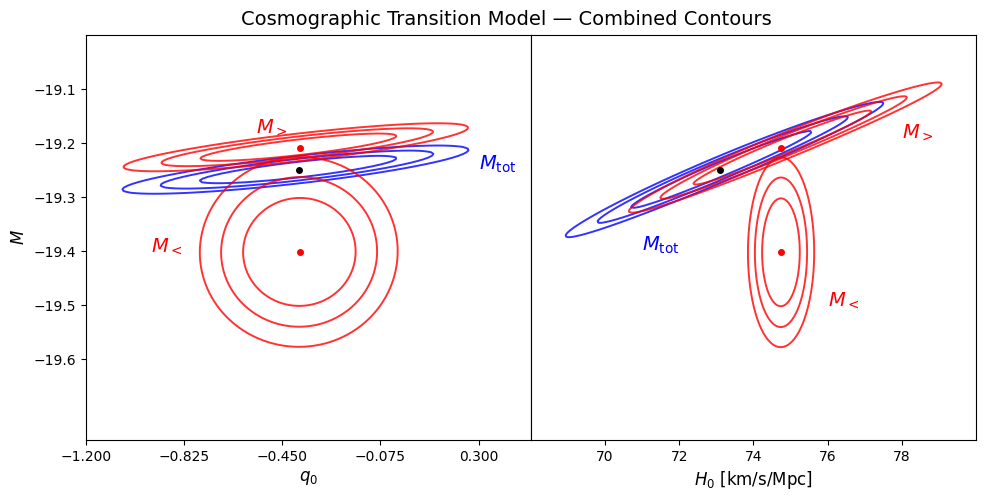

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.special import erf, gammaincinv

# --- Load all contour data ---
data_M_H0     = np.load("contour_data/contour_data_M_H0_cosmography.npz")
data_M_q0     = np.load("contour_data/contour_data_M_q0_cosmography.npz")
data_Mlow_H0  = np.load("contour_data/contour_data_Mlow_H0_cosmography.npz")
data_Mhigh_H0 = np.load("contour_data/contour_data_Mhigh_H0_cosmography.npz")
data_Mlow_q0  = np.load("contour_data/contour_data_Mlow_q0_cosmography.npz")
data_Mhigh_q0 = np.load("contour_data/contour_data_Mhigh_q0_cosmography.npz")

# --- Extract ranges and chi2 grids ---
H0_range       = data_M_H0["H0"]
q0_range       = data_M_q0["q0"]
M_range        = data_M_H0["M"]
Mlow_range_H0  = data_Mlow_H0["Mlow"]
Mhigh_range_H0 = data_Mhigh_H0["Mhigh"]
Mlow_range_q0  = data_Mlow_q0["Mlow"]
Mhigh_range_q0 = data_Mhigh_q0["Mhigh"]
q0_range_low   = data_Mlow_q0["q0_tr"]
q0_range_high  = data_Mhigh_q0["q0_tr"]

chi2_MH0       = data_M_H0["chi2"]
chi2_Mq0       = data_M_q0["chi2"]
chi2_Mlow_H0   = data_Mlow_H0["chi2"]
chi2_Mhigh_H0  = data_Mhigh_H0["chi2"]
chi2_Mlow_q0   = data_Mlow_q0["chi2"]
chi2_Mhigh_q0  = data_Mhigh_q0["chi2"]

# --- Best-fit values ---
H0_best = data_M_H0["H0_best"]
q0_best = data_M_q0["q0_best"]
M_best  = data_M_H0["M_best"]

H0_best_tr     = data_Mlow_H0["H0_tr_best"]
q0_best_tr     = data_Mlow_q0["q0_tr_best"]
M_low_best     = data_Mlow_H0["M_low_best"]
M_high_best    = data_Mhigh_H0["M_high_best"]

# --- Delta chi2 normalization ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gammaincinv(dof / 2, p)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

dchi2_MH0       = chi2_MH0 - np.min(chi2_MH0)
dchi2_Mq0       = chi2_Mq0 - np.min(chi2_Mq0)
dchi2_Mlow_H0   = chi2_Mlow_H0 - np.min(chi2_Mlow_H0)
dchi2_Mhigh_H0  = chi2_Mhigh_H0 - np.min(chi2_Mhigh_H0)
dchi2_Mlow_q0   = chi2_Mlow_q0 - np.min(chi2_Mlow_q0)
dchi2_Mhigh_q0  = chi2_Mhigh_q0 - np.min(chi2_Mhigh_q0)

# --- Plotting combined figure ---
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
gs.update(wspace=0.0)

# --- LEFT: M vs q0 ---
ax1 = plt.subplot(gs[0])
ax1.contour(q0_range, M_range, dchi2_Mq0, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax1.contour(q0_range_low, Mlow_range_q0, dchi2_Mlow_q0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax1.contour(q0_range_high, Mhigh_range_q0, dchi2_Mhigh_q0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)

ax1.plot(q0_best, M_best, 'ko', markersize=4)
ax1.plot(q0_best_tr, M_low_best, 'ro', markersize=4)
ax1.plot(q0_best_tr, M_high_best, 'ro', markersize=4)
ax1.text(-0.95, -19.40, r"$M_{<}$", color='red', fontsize=14)
ax1.text(-0.55, -19.18, r"$M_{>}$", color='red', fontsize=14)
ax1.text(0.30, -19.25, r"$M_{\mathrm{tot}}$", color='blue', fontsize=14)
ax1.set_xlabel(r"$q_0$", fontsize=12)
ax1.set_ylabel(r"$M$", fontsize=12)
ax1.set_xlim(q0_range.min(), q0_range.max())
ax1.set_ylim(-19.75, -19.00)
ax1.set_xticks(np.linspace(-1.2, 0.3, 5))
ax1.set_yticks(np.linspace(-19.6, -19.1, 6))
ax1.tick_params(axis='both', labelsize=10)

# --- RIGHT: M vs H0 ---
ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.contour(H0_range, M_range, dchi2_MH0, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax2.contour(H0_range, Mlow_range_H0, dchi2_Mlow_H0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax2.contour(H0_range, Mhigh_range_H0, dchi2_Mhigh_H0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)

ax2.plot(H0_best, M_best, 'ko', markersize=4)
ax2.plot(H0_best_tr, M_low_best, 'ro', markersize=4)
ax2.plot(H0_best_tr, M_high_best, 'ro', markersize=4)
ax2.text(78, -19.19, r"$M_{>}$", color='red', fontsize=14)
ax2.text(76, -19.50, r"$M_{<}$", color='red', fontsize=14)
ax2.text(71.0, -19.40, r"$M_{\mathrm{tot}}$", color='blue', fontsize=14)
ax2.set_xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
ax2.set_xlim(H0_range.min(), H0_range.max())
ax2.set_xticks([70, 72, 74, 76, 78])
ax2.tick_params(axis='y', labelleft=False, left=False)

# --- Final adjustments and save ---
plt.subplots_adjust(left=0.08, right=0.97, bottom=0.12, top=0.93)
plt.suptitle("Cosmographic Transition Model — Combined Contours", fontsize=14)
plt.savefig("Cosmographic_Combined_Contours.png", dpi=300)
plt.show()


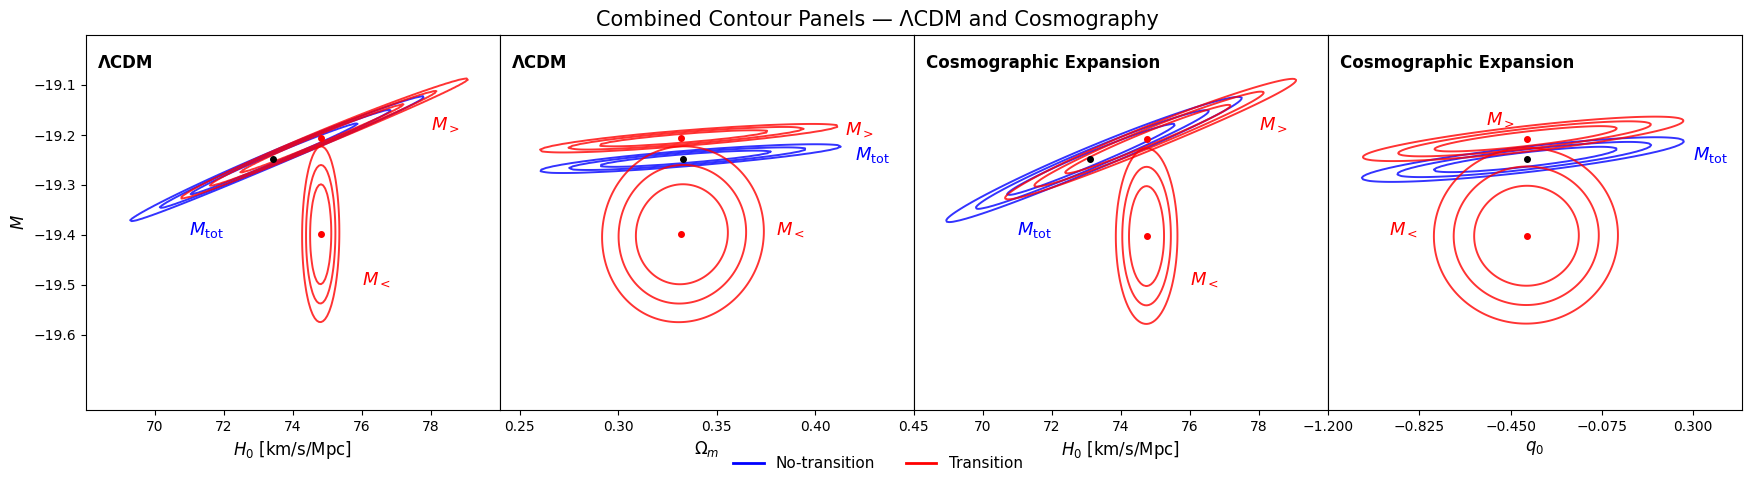

In [3]:
# === Load all cosmographic contour data ===
data_M_H0_COSMO     = np.load("contour_data/contour_data_M_H0_cosmography.npz")
data_M_q0_COSMO     = np.load("contour_data/contour_data_M_q0_cosmography.npz")
data_Mlow_H0_COSMO  = np.load("contour_data/contour_data_Mlow_H0_cosmography.npz")
data_Mhigh_H0_COSMO = np.load("contour_data/contour_data_Mhigh_H0_cosmography.npz")
data_Mlow_q0_COSMO  = np.load("contour_data/contour_data_Mlow_q0_cosmography.npz")
data_Mhigh_q0_COSMO = np.load("contour_data/contour_data_Mhigh_q0_cosmography.npz")

# === Load all ΛCDM contour data ===
data_M_H0_LCDM     = np.load("contour_data/contour_data_M_H0.npz")
data_M_Om_LCDM     = np.load("contour_data/contour_data_M_Om.npz")
data_Mlow_H0_LCDM  = np.load("contour_data/contour_data_Mlow_H0.npz")
data_Mhigh_H0_LCDM = np.load("contour_data/contour_data_Mhigh_H0.npz")
data_Mlow_Om_LCDM  = np.load("contour_data/contour_data_Mlow_Om.npz")
data_Mhigh_Om_LCDM = np.load("contour_data/contour_data_Mhigh_Om.npz")

# === Extract cosmographic grids and chi² values ===
H0_range_COSMO         = data_M_H0_COSMO["H0"]
q0_range_COSMO         = data_M_q0_COSMO["q0"]
M_range_COSMO          = data_M_H0_COSMO["M"]
Mlow_range_H0_COSMO    = data_Mlow_H0_COSMO["Mlow"]
Mhigh_range_H0_COSMO   = data_Mhigh_H0_COSMO["Mhigh"]
Mlow_range_q0_COSMO    = data_Mlow_q0_COSMO["Mlow"]
Mhigh_range_q0_COSMO   = data_Mhigh_q0_COSMO["Mhigh"]
q0_range_low_COSMO     = data_Mlow_q0_COSMO["q0_tr"]
q0_range_high_COSMO    = data_Mhigh_q0_COSMO["q0_tr"]

chi2_MH0_COSMO         = data_M_H0_COSMO["chi2"]
chi2_Mq0_COSMO         = data_M_q0_COSMO["chi2"]
chi2_Mlow_H0_COSMO     = data_Mlow_H0_COSMO["chi2"]
chi2_Mhigh_H0_COSMO    = data_Mhigh_H0_COSMO["chi2"]
chi2_Mlow_q0_COSMO     = data_Mlow_q0_COSMO["chi2"]
chi2_Mhigh_q0_COSMO    = data_Mhigh_q0_COSMO["chi2"]

# === Extract ΛCDM grids and chi² values ===
H0_range_LCDM          = data_M_H0_LCDM["H0"]
Om_range_LCDM          = data_M_Om_LCDM["Om"]
M_range_LCDM           = data_M_H0_LCDM["M"]
Mlow_range_H0_LCDM     = data_Mlow_H0_LCDM["Mlow"]
Mhigh_range_H0_LCDM    = data_Mhigh_H0_LCDM["Mhigh"]
Mlow_range_Om_LCDM     = data_Mlow_Om_LCDM["Mlow"]
Mhigh_range_Om_LCDM    = data_Mhigh_Om_LCDM["Mhigh"]
Om_range_low_LCDM      = data_Mlow_Om_LCDM["Om"]
Om_range_high_LCDM     = data_Mhigh_Om_LCDM["Om"]

chi2_MH0_LCDM          = data_M_H0_LCDM["chi2"]
chi2_MOm_LCDM          = data_M_Om_LCDM["chi2"]
chi2_Mlow_H0_LCDM      = data_Mlow_H0_LCDM["chi2"]
chi2_Mhigh_H0_LCDM     = data_Mhigh_H0_LCDM["chi2"]
chi2_Mlow_Om_LCDM      = data_Mlow_Om_LCDM["chi2"]
chi2_Mhigh_Om_LCDM     = data_Mhigh_Om_LCDM["chi2"]

# --- Cosmography: Best-fit values ---
H0_best_COSMO        = data_M_H0_COSMO["H0_best"]
q0_best_COSMO        = data_M_q0_COSMO["q0_best"]
M_best_COSMO         = data_M_H0_COSMO["M_best"]

H0_best_tr_COSMO     = data_Mlow_H0_COSMO["H0_tr_best"]
q0_best_tr_COSMO     = data_Mlow_q0_COSMO["q0_tr_best"]
M_low_best_COSMO     = data_Mlow_H0_COSMO["M_low_best"]
M_high_best_COSMO    = data_Mhigh_H0_COSMO["M_high_best"]

# --- ΛCDM: Best-fit values ---
H0_best_LCDM         = data_M_H0_LCDM["H0_best"]
Om_best_LCDM         = data_M_Om_LCDM["Om_best"]
M_best_LCDM          = data_M_H0_LCDM["M_best"]

H0_best_tr_LCDM      = data_Mlow_H0_LCDM["H0_best"]
Om_best_tr_LCDM      = data_Mlow_Om_LCDM["Om_best"]
M_low_best_LCDM      = data_Mlow_H0_LCDM["M_low_best"]
M_high_best_LCDM     = data_Mhigh_H0_LCDM["M_high_best"]

# --- Delta chi2 normalization (COSMO) ---
dchi2_MH0_COSMO       = chi2_MH0_COSMO - np.min(chi2_MH0_COSMO)
dchi2_Mq0_COSMO       = chi2_Mq0_COSMO - np.min(chi2_Mq0_COSMO)
dchi2_Mlow_H0_COSMO   = chi2_Mlow_H0_COSMO - np.min(chi2_Mlow_H0_COSMO)
dchi2_Mhigh_H0_COSMO  = chi2_Mhigh_H0_COSMO - np.min(chi2_Mhigh_H0_COSMO)
dchi2_Mlow_q0_COSMO   = chi2_Mlow_q0_COSMO - np.min(chi2_Mlow_q0_COSMO)
dchi2_Mhigh_q0_COSMO  = chi2_Mhigh_q0_COSMO - np.min(chi2_Mhigh_q0_COSMO)

# --- Delta chi2 normalization (LCDM) ---
dchi2_MH0_LCDM       = chi2_MH0_LCDM - np.min(chi2_MH0_LCDM)
dchi2_MOm_LCDM       = chi2_MOm_LCDM - np.min(chi2_MOm_LCDM)
dchi2_Mlow_H0_LCDM   = chi2_Mlow_H0_LCDM - np.min(chi2_Mlow_H0_LCDM)
dchi2_Mhigh_H0_LCDM  = chi2_Mhigh_H0_LCDM - np.min(chi2_Mhigh_H0_LCDM)
dchi2_Mlow_Om_LCDM   = chi2_Mlow_Om_LCDM - np.min(chi2_Mlow_Om_LCDM)
dchi2_Mhigh_Om_LCDM  = chi2_Mhigh_Om_LCDM - np.min(chi2_Mhigh_Om_LCDM)

from matplotlib import gridspec
from scipy.special import gammaincinv, erf

# --- Delta chi2 confidence levels ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gammaincinv(dof / 2, p)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

# --- Create 4-panel layout ---
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])
gs.update(wspace=0.0)

# ======================
# Panel 1: ΛCDM — M vs H0
# ======================
ax1 = plt.subplot(gs[0])
ax1.contour(H0_range_LCDM, M_range_LCDM, dchi2_MH0_LCDM, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax1.contour(H0_range_LCDM, Mlow_range_H0_LCDM, dchi2_Mlow_H0_LCDM, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax1.contour(H0_range_LCDM, Mhigh_range_H0_LCDM, dchi2_Mhigh_H0_LCDM, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax1.plot(H0_best_LCDM, M_best_LCDM, 'ko', markersize=4)
ax1.plot(H0_best_tr_LCDM, M_low_best_LCDM, 'ro', markersize=4)
ax1.plot(H0_best_tr_LCDM, M_high_best_LCDM, 'ro', markersize=4)
ax1.set_xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
ax1.set_ylabel(r"$M$", fontsize=12)
ax1.set_xlim(H0_range_LCDM.min(), H0_range_LCDM.max())
ax1.set_ylim(-19.75, -19.00)
ax1.set_xticks([70, 72, 74, 76, 78])
ax1.set_yticks(np.linspace(-19.6, -19.1, 6))
ax1.text(78, -19.19, r"$M_{>}$", color='red', fontsize=13)
ax1.text(76, -19.50, r"$M_{<}$", color='red', fontsize=13)
ax1.text(71.0, -19.40, r"$M_{\mathrm{tot}}$", color='blue', fontsize=13)
ax1.tick_params(axis='both', labelsize=10)

# ======================
# Panel 2: ΛCDM — M vs Om
# ======================
ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.contour(Om_range_LCDM, M_range_LCDM, dchi2_MOm_LCDM, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax2.contour(Om_range_low_LCDM, Mlow_range_Om_LCDM, dchi2_Mlow_Om_LCDM, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax2.contour(Om_range_high_LCDM, Mhigh_range_Om_LCDM, dchi2_Mhigh_Om_LCDM, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax2.plot(Om_best_LCDM, M_best_LCDM, 'ko', markersize=4)
ax2.plot(Om_best_tr_LCDM, M_low_best_LCDM, 'ro', markersize=4)
ax2.plot(Om_best_tr_LCDM, M_high_best_LCDM, 'ro', markersize=4)
ax2.set_xlabel(r"$\Omega_m$", fontsize=12)
ax2.set_xlim(Om_range_LCDM.min(), Om_range_LCDM.max())
ax2.set_xticks([0.25, 0.30, 0.35, 0.40, 0.45])
ax2.tick_params(axis='y', labelleft=False, left=False)
ax2.text(0.38, -19.40, r"$M_{<}$", color='red', fontsize=13)
ax2.text(0.415, -19.20, r"$M_{>}$", color='red', fontsize=13)
ax2.text(0.42, -19.25, r"$M_{\mathrm{tot}}$", color='blue', fontsize=13)

# ======================
# Panel 3: Cosmography — M vs H0
# ======================
ax3 = plt.subplot(gs[2], sharey=ax1)
ax3.contour(H0_range_COSMO, M_range_COSMO, dchi2_MH0_COSMO, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax3.contour(H0_range_COSMO, Mlow_range_H0_COSMO, dchi2_Mlow_H0_COSMO, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax3.contour(H0_range_COSMO, Mhigh_range_H0_COSMO, dchi2_Mhigh_H0_COSMO, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax3.plot(H0_best_COSMO, M_best_COSMO, 'ko', markersize=4)
ax3.plot(H0_best_tr_COSMO, M_low_best_COSMO, 'ro', markersize=4)
ax3.plot(H0_best_tr_COSMO, M_high_best_COSMO, 'ro', markersize=4)
ax3.set_xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
ax3.set_xlim(H0_range_COSMO.min(), H0_range_COSMO.max())
ax3.set_xticks([70, 72, 74, 76, 78])
ax3.tick_params(axis='y', labelleft=False, left=False)
ax3.text(78, -19.19, r"$M_{>}$", color='red', fontsize=13)
ax3.text(76, -19.50, r"$M_{<}$", color='red', fontsize=13)
ax3.text(71.0, -19.40, r"$M_{\mathrm{tot}}$", color='blue', fontsize=13)

# ======================
# Panel 4: Cosmography — M vs q0
# ======================
ax4 = plt.subplot(gs[3], sharey=ax1)
ax4.contour(q0_range_COSMO, M_range_COSMO, dchi2_Mq0_COSMO, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax4.contour(q0_range_low_COSMO, Mlow_range_q0_COSMO, dchi2_Mlow_q0_COSMO, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax4.contour(q0_range_high_COSMO, Mhigh_range_q0_COSMO, dchi2_Mhigh_q0_COSMO, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax4.plot(q0_best_COSMO, M_best_COSMO, 'ko', markersize=4)
ax4.plot(q0_best_tr_COSMO, M_low_best_COSMO, 'ro', markersize=4)
ax4.plot(q0_best_tr_COSMO, M_high_best_COSMO, 'ro', markersize=4)
ax4.set_xlabel(r"$q_0$", fontsize=12)
ax4.set_xlim(q0_range_COSMO.min(), q0_range_COSMO.max())
ax4.set_xticks(np.linspace(-1.2, 0.3, 5))
ax4.tick_params(axis='y', labelleft=False, left=False)
ax4.text(-0.95, -19.40, r"$M_{<}$", color='red', fontsize=13)
ax4.text(-0.55, -19.18, r"$M_{>}$", color='red', fontsize=13)
ax4.text(0.30, -19.25, r"$M_{\mathrm{tot}}$", color='blue', fontsize=13)

# === Final layout ===
plt.subplots_adjust(left=0.06, right=0.98, bottom=0.18, top=0.93)  # extra space for legend
plt.suptitle("Combined Contour Panels — ΛCDM and Cosmography", fontsize=15)

# --- Add annotations and legend ---
ax1.text(0.03, 0.95, "ΛCDM", transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')
ax2.text(0.03, 0.95, "ΛCDM", transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top')
ax3.text(0.03, 0.95, "Cosmographic Expansion", transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top')
ax4.text(0.03, 0.95, "Cosmographic Expansion", transform=ax4.transAxes, fontsize=12, fontweight='bold', va='top')

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='blue', lw=2, label='No-transition'),
    Line2D([0], [0], color='red', lw=2, label='Transition')
]
fig.legend(handles=custom_lines, loc='lower center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, 0.03))

# --- Save and show ---
plt.savefig("Combined_4Panel_Contours_Annotated.png", dpi=300)
plt.show()

